<h1><center> Recuperação 1 </center></h1>
    
<h6> Maurício Jesuíno Nogueira <br>
00263071</h6>

<h6> <center> 30 de novembro de 2021 </center></h6>


1. Comparem a arquitetura do AVR vs Z80
2. Implementem o algoritmo do selection sort em pic ou Avr

* **Comparem a arquitetura do AVR vs Z80**

<text> O Zilog Z80 é um microprocessador muito utilizado, com aplicações em videogames - Sega Master System, Sega Mega Drive - calculadoras e outros dispositivos. A arquitetura do Z80 segue abaixo, como disponível no datasheet: </text>

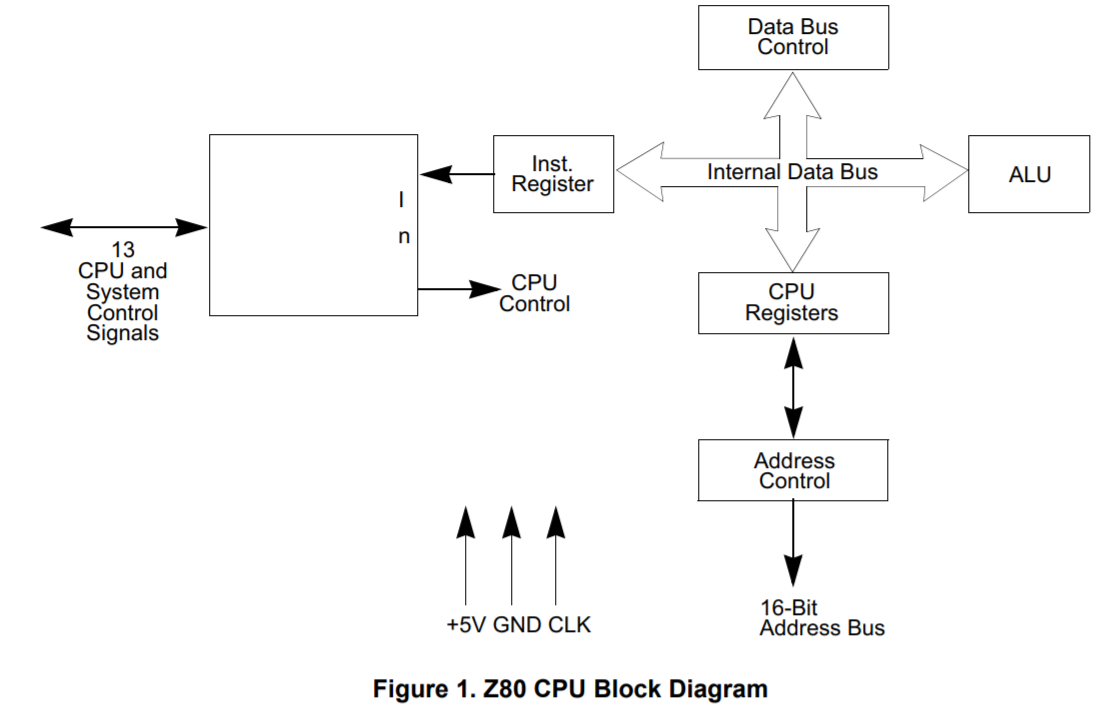

<text> O AVR ATmega328p, por sua vez, é um microprocessador muito utilizado em projetos, principalmente em prototipagem e aprendizado, sendo o microprocessador utilizado no Arduino Nano e Uno. A sua arquitetura, como disponível no datasheet, é: </text>

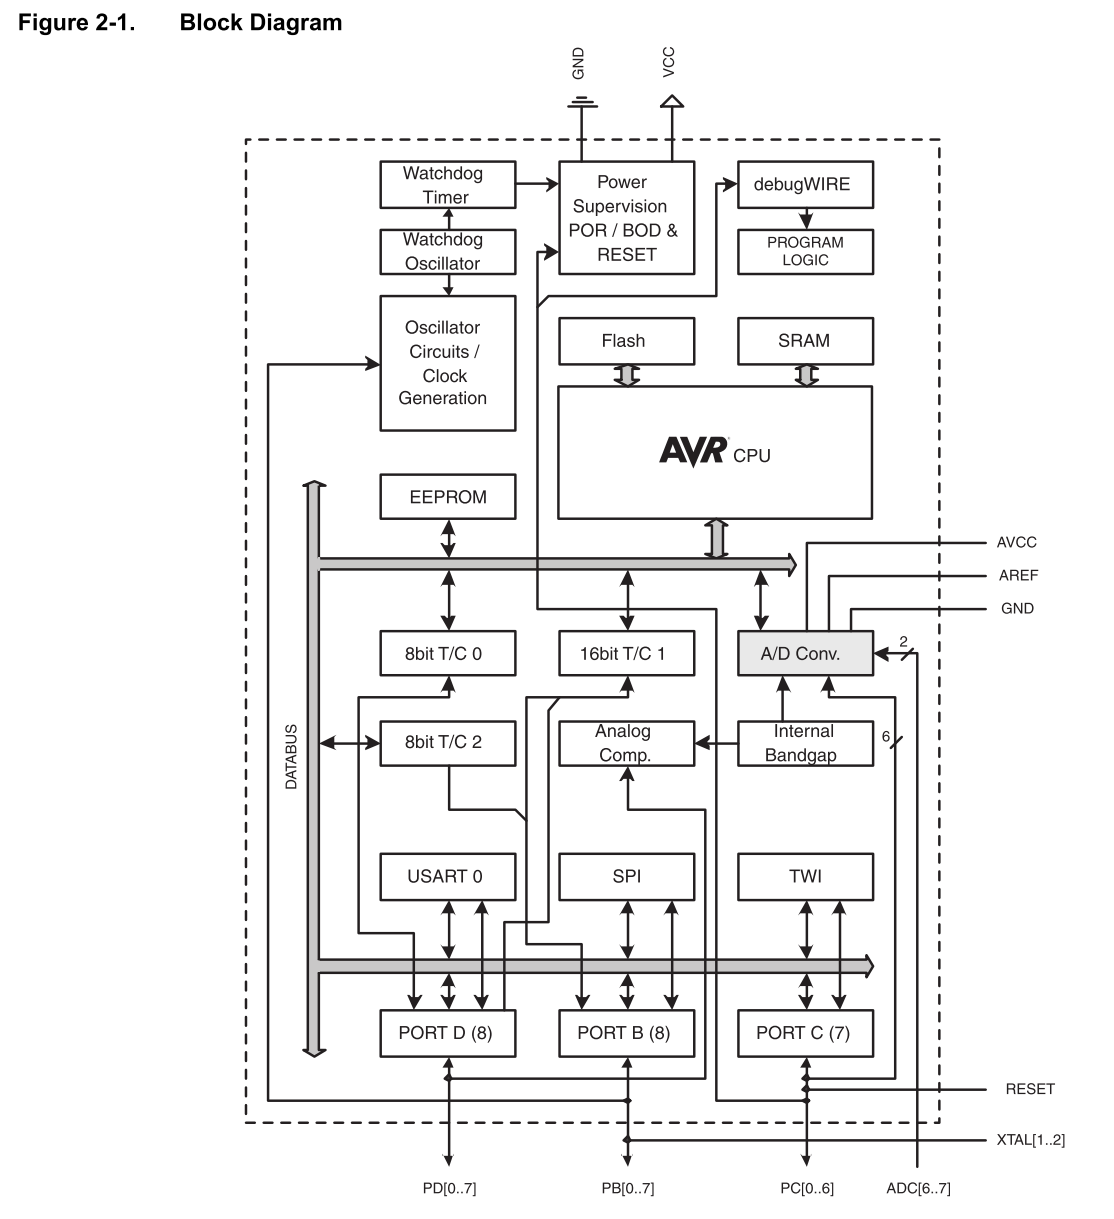

<text> E a arquitetura da CPU pode ser mais detalhada, estando também disponível no datasheet </text>

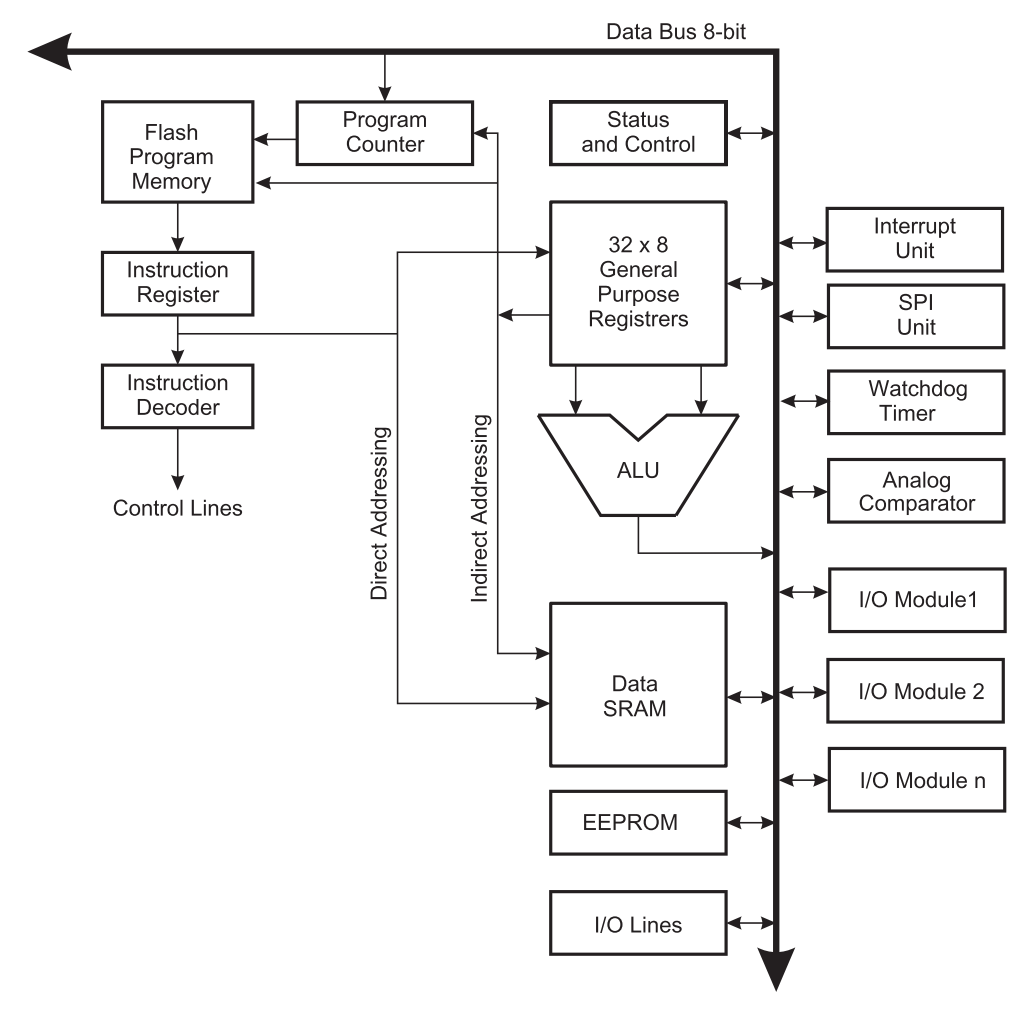

<text> Comparando as duas arquiteturas é possível perceber que a arquitetura do AVR é mais complexa (e completa), com mais partes. Isso se dá, pois o ATMega328p é um micro**controlador** enquanto o Zilog Z80 é um micro**processador**. Isto significa que o AVR já vem com outros componentes além da CPU como ROM, RAM, portas de I/O e outros periféricos (timers, por exemplo). Como resultado, o AVR é uma solução completa e o Z80 necessita de um oscilador, memória e circuitos de I/O externos para funcionar. <br>

Comparando as arquiteturas das CPUs, o Z80 possui 18 registradores de 8-bits e 4 de 16-bits, totalizando 208 bits. Dois dos registradores de 16-bits são utilizados para indexação (IX e IY) e dois são utilizados para armazenar o endereço do topo de uma RAM externa (*Stack Pointer - SP*) e como contador do programa (*Program Counter - PC*). Outros dois registradores com funções especiais são para atualização da memória e interrupções (R e I, respectivamente). Os registradores restantes possuem uso geral, com alguns possuindo a possibilidade de utilização como acumulador (armazenando resultados de operações lógicas e aritméticas) e outros registrando flags. O AVR, por outro lado, possui 32 registradores de 8-bits para uso geral, sendo que 6 deles podem ser utilizados para acesso da memória por endereçamento indireto (3 pares de 16-bits, cada). São eles, os registradores X (R26 e R27), Y (R28 e R29) e Z (R30 e R31). <br>
    
O AVR possui arquitetura Harvard, o que significa que a memória de dados é separada da memória de programa (*Flash memory e Data memory*). Além disso, como pode ser visto pelo diagrama, a Unidade Lógico-Aritmética (*ALU em inglês*) possui entrada de registradores apenas, ou seja, todas operações realizada pela ALU devem ser feitas via registradores. O AVR tem arquitetura RISC. O Z80, por sua vez, possui arquitetura Von Neumann com a memória de programa e de dados no mesmo local, o que pode configurar um gargalo na execução de programas.</text>

* **Implemente o algoritmo do Selection Sort em Pic ou AVR.**

<text>O algoritmo de selection sort funciona da seguinte maneira:</text>

* Pegar o primeiro valor da lista que queremos ordenar
* Comparar com o segundo valor da lista
* O valor que for menor é 'separado' para ser comparado com terceiro valor
* Comparamos o valor 'separado' com o terceiro e novamente escolhemos o menor
* Assim seguimos comparando e 'separando' o menor até o fim da lista
* Ao chegar no fim da lista, trocamos o valor 'separado' de posição com o primeiro
* Recomeçamos o algoritmo a partir do segundo valor da lista, depois do terceiro...
* ... até o fim da lista

<text> Ao chegar no fim da lista, ela está ordenada! <br>
        
Decidi desenvolver o programa do *Selection Sort* em assembly para o AVR. Para isso, iniciei armazenando os valores da lista (desordenados) na SRAM, com a subrotina *arrayInit*. <br>
    
O registrador R16 armazena o tamanho da lista.
    
Em seguida utilizei os registrador R17 para funcionar como iterador do loop externo: começa no primeiro valor da lista e vai até o penúltimo (pois quando chegamos no último a lista já está ordenada). <br>
    
O registrador R18 funciona como iterador do loop interno: começa em R16 + 1 e vai até o fim da lista selecionando dado com o qual o menor valor até o momento será comparado. Quando ele atinge o comprimento da lista está na hora de fazer a troca de posições. <br>
    
O registrador R19 armazena a posição do menor valor encontrado. <br>
    
Os registradores R21 e R22 armazenam os valores correspondentes às posições de R19 e R18 na lista. Ou seja, para uma lista A qualquer: R21 = A[R19] e R22 = A[R18]. <br>
    
Estes valores foram definidos na subrotina e são atualizados a cada iteração ou quando o programa entra na subrotina Subst. <br>
    
A subrotina *Subst* tem a função de fazer a substituição do menor valor separado com os quais os outros são comparados. Ela é chamada sempre que o valor separado é maior que o comparado. <br>
    
A subrotina *Swap* é chamada quando o registrador R18 atinge o valor máximo (tamanho da lista) e realiza a troca do menor valor com o na posição do R17.<br>
    
A subrotina *pointerPositioning* atribui os valores corretos para R21 e R22 antes do início de um loop interno. <br>
    
Por fim, foi feito o uso do endereçamento indireto com os resgistradores X e Y em diversas partes do programa para facilitar a obtenção e alteração de valores da lista. <br></text>

<h6>Programa em Assembly Selection Sort:</h6>

In [ ]:
;
; ***********************************
; *         Selection Sort          *
; *    Maurício Jesuíno Nogueira    *
; *           00263071              *
; ***********************************
;
.nolist
.include "m328pdef.inc" ; Define device ATmega328P
.list
;

.org 0x0000
rjmp Init

Init:
     ldi R16, low(RAMEND) ; stack init
     out SPL, R16
     ldi R17, high(RAMEND)
     out SPH, R17

Main:
     rcall arrayInit  ; Initialize array

     ldi R16, 0x0A ; size of the array
     ldi R17, 0x01 ;external loop (i)

External:
     inc R16 ; because loop starts wiht (i) = 1
     mov R18, R17
     inc R18 ; internal loop index (j = i + 1)
     mov R19, R17 ; (k = i)
     rcall PointerPositioning

     ;clr R19 ; smallest number index

Internal:
      ld R22, Y+ ; A[j]
      cp R21, R22 ; cp Rd, Rr --> cp A[k], A[j] --> sets C if A[j] > A[k]

      in R23, SREG
      sbrs R23, 0
      rcall Subst  ; subst if Rd >= Rr
      clc
      inc R18
      cpse R18, R16
      rjmp Internal

      rcall Swap
      inc R17
      dec R16 ; once the penultimate number is sorted so is the last
      cpse R17, R16
      rjmp External

rjmp FIM

PointerPositioning:
     ldi XL, 0xE0
     ldi XH, 0x08

     ldi YL, 0xE0
     ldi YH, 0x08

     clr R20

     posit:
          ld R21, X+ ; A[k]
          ld R22, Y+ ; A[j]

          inc R20
          cpse R20, R17
          rjmp posit


     ret

Subst:
     mov R19, R18 ; k = j
     ldi XL, 0xE0
     add XL, R19
     ld R21, -X
     ret

Swap:
     ldi XL, 0xE0
     ldi XH, 0x08
     add XL, R17 ; A[i] adsress

     ldi YL, 0xE0
     ldi YH, 0x08
     add YL, R19 ; A[k] adsress

     ld R20, -X ; A[i]
     ld R21, -Y; A[k]
     st X, R21; A[i] = A[k]
     st Y, R20 ; A[k] = A[i]

     ret



arrayInit:
     ldi XL, 0xE0
     ldi XH, 0x08

     ldi R16, 0x09
     st X+, R16

     ldi R16, 0x07
     st X+, R16

     ldi R16, 0x08
     st X+, R16

     ldi R16, 0x05
     st X+, R16

     ldi R16, 0x04
     st X+, R16

     ldi R16, 0x09
     st X+, R16

     ldi R16, 0x06
     st X+, R16

     ldi R16, 0x0E
     st X+, R16

     ldi R16, 0x0B
     st X+, R16

     ldi R16, 0x0D
     st X+, R16


     ret

FIM:
     rjmp FIM
                  

<text> Abaixo, imagem com o programa concluido:</text>

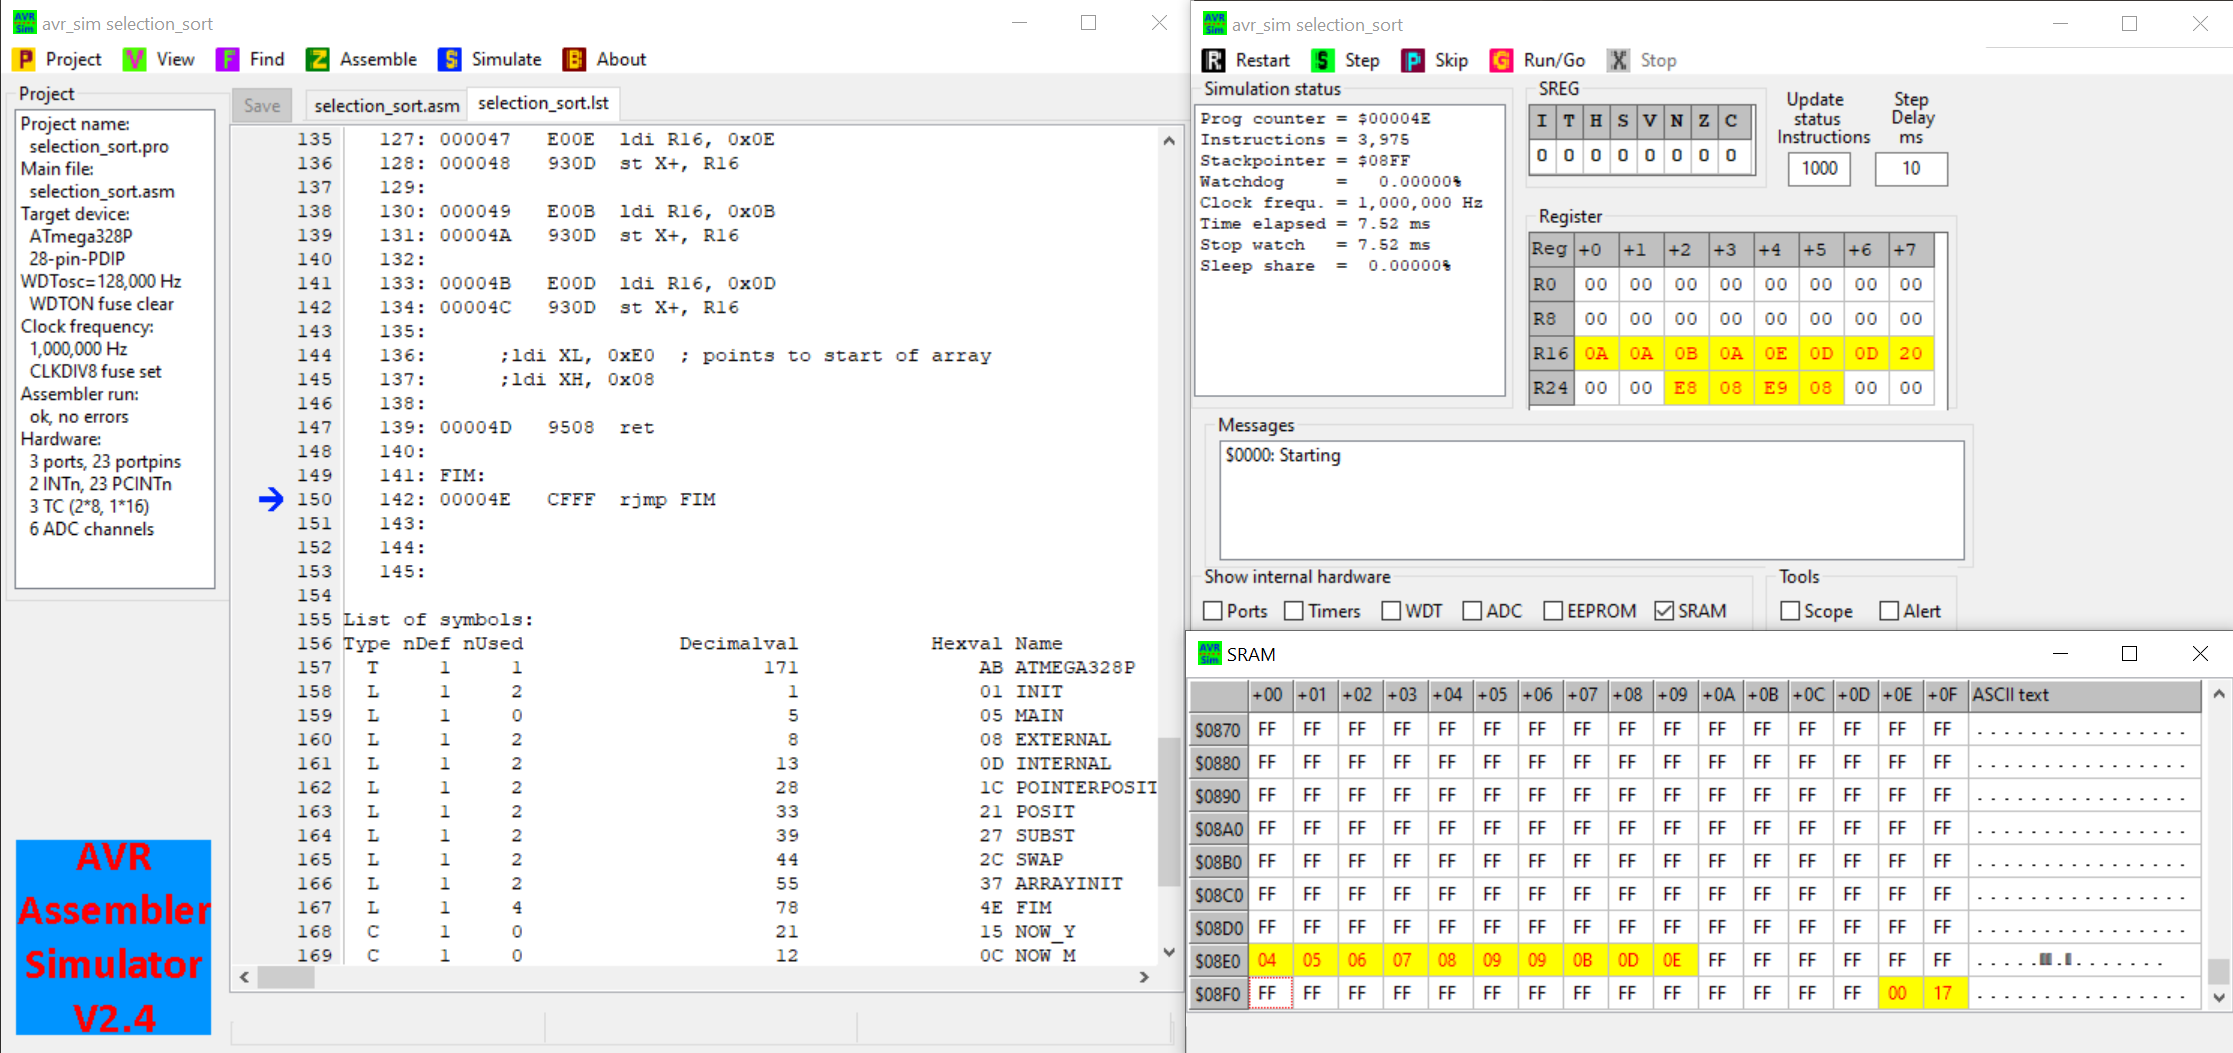